# 1. Problem Definition

This document outlines the synthetic data generation framework focused on augmenting the minority class to improve machine learning performance on the UCI Adults dataset for income prediction. In this context, the minority class comprises individuals earning more than $50K per year.

---

## 1.1 Objective

- **Primary Goal:**  
  Enhance the performance of a binary classifier for income prediction on the UCI Adults dataset by augmenting the minority class (individuals earning >$50K) using synthetic data. The primary focus is on improving key metrics—especially increasing recall and F1-score for the high-income group.

- **Dataset Description:**  
  The UCI Adults dataset consists of census data that includes demographic, educational, and employment-related features. The target variable, "income," indicates whether an individual earns more than $50K per year. The data has been anonymized to protect individual privacy.

- **Desired Outcomes:**  
  - Increase the recall for the minority (> $50K) class by at least 10% over a baseline.
  - Improve overall balanced accuracy and the F1-score for the high-income group.
  - Achieve statistically significant improvements (e.g., p < 0.05 in performance comparisons) compared to a model trained on the original imbalanced dataset.

---

## 1.2 Scope & Constraints

- **Data Focus:**  
  - Both numeric and categorical features are important. Numeric features (e.g., age, education_num, capital_gain) and categorical features (e.g., workclass, marital_status) will be appropriately preprocessed. 
  - All features are preprocessed, ensuring consistency in scaling and encoding.

- **Computational Resources:**  
  - The dataset is moderately sized (≈32K instances), so available computational resources are typically sufficient.
  - When using deep generative models (e.g., GANs, VAEs, diffusion models) for synthetic data generation, GPU acceleration may be preferred.
  - Optional dimensionality reduction techniques (PCA) might be applied for additional feature engineering or noise reduction.

- **Augmentation Strategy:**  
  - The strategy focuses on balancing the minority (> $50K) class with the majority (≤ $50K) class by generating synthetic samples exclusively for the training set.
  - To prevent over-amplification, especially for very small classes, the effect of the augmentation ratio is deliberately diminished via a scaling factor.
  - Synthetic data will be used only for training; an untouched test set will remain for unbiased evaluation.

- **Technical Limitations:**  
  - For smaller datasets, simpler methods SMOTE may suffice; however, deep generative methods will be considered if capturing complex non-linear relationships is necessary.
  - Training stability and potential mode collapse in deep generative models will be monitored closely.

---

## 1.3 Ethical and Regulatory Considerations

- **Data Sensitivity & Privacy:**  
  - The dataset contains sensitive demographic and employment data. Despite anonymization, privacy is paramount.
  - The framework will adhere to best practices for data privacy and comply with relevant regulations (e.g., HIPAA, GDPR).

- **Bias and Fairness:**  
  - Demographic biases (e.g., gender/race) may affect income predictions.
  - The synthetic data generation process will include checks to ensure that augmented data does not exacerbate existing biases and that demographic representation remains balanced.

- **Regulatory Compliance:**  
  - The project will comply with ethical standards and institutional guidelines for handling sensitive data.
  - All decisions related to data handling and synthetic augmentation will be thoroughly documented to support transparency and ethical reviews.

---

## 1.4 Target Outcomes & Success Criteria

- **Performance Metrics:**  
  - **Primary Metrics:**  
    - Achieve at least a 10% increase in recall for the minority (> $50K) class over the baseline.
    - Improve the F1-score for the high-income class.

  - **Secondary Metrics:**  
    - Overall balanced accuracy.
    - ROC-AUC and PR-AUC scores for the binary classification task.
  - Some trade-offs such as a slight drop in precision may be acceptable if the recall improvement is significant.

- **Ethical Benchmarks:**  
  - Synthetic data must be statistically similar to the real minority data in terms of key summary statistics (mean, variance, etc.).
  - Fairness metrics (e.g., equalized odds) should indicate that the augmented data does not introduce new biases.
  - Validation tests (such as Kolmogorov–Smirnov and chi-squared tests) should confirm that the synthetic and real data distributions do not differ significantly.

---

*This document will be updated as the framework progresses through subsequent stages, ensuring that technical decisions, ethical considerations, and performance benchmarks are continuously documented and refined.*


# Data Processing

I chose to implement the data processing script of DataPrepv1.py, the code is executed below and then followed up with the markdown file conducting analysis on the outputs.

In [1]:
from DataProcessingMethods.DataPrepv1 import prepare_data_pipeline
import pandas as pd
#Data Loading and Preparation
#Load the UCI Adult dataset.
#Missing values are indicated by "?".
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dataset_name = "Adult Dataset"
df = pd.read_csv("Datasets/adultUCI.csv", na_values="?")
list_features_specialise_outliers = ["hours_per_week"]
numeric_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
dist_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
target = "income"

df_no_outliers = prepare_data_pipeline(
    df, 
    list_features_specialise_outliers, 
    numeric_features, 
    dist_features, 
    target
)

df_no_outliers[numeric_features] = scaler.fit_transform(df_no_outliers[numeric_features])


Rows before cleaning empty values: 32561
Rows after cleaning empty values: 30162
Rows after dropping duplicates: 30139


DataFrame head:
   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week

In [2]:
import pandas as pd
from DataProcessingMethods.BiasAnalysisV2 import analyse_demographics

results = analyse_demographics(
    df=df_no_outliers,
    sensitive_attrs=['race', 'sex', 'native_country'],
    target_col='income',
    output_dir='demographic_analysis'
)


Analyzing race...

Analyzing sex...

Analyzing native_country...
Demographic analysis complete! Results saved to demographic_analysis


# 2 Data Assessment & Ethical Analysis

This section outlines the data assessment process and ethical considerations for the synthetic data generation framework aimed at augmenting the minority class within the UCI Adults dataset. The goal is to improve the performance of predictive models by addressing class imbalance for income prediction (i.e., individuals earning >50K per year), while ensuring that ethical and privacy considerations are maintained.

---

## 2.1 Data Assessment

### 2.1.1 Data Loading and Cleaning

- **Dataset Source:**  
  The UCI Adults dataset is loaded from the `Datasets/adultUCI.csv` file.
  
- **Missing Values Handling:**  
  - Missing values represented as "?" are converted to `NaN` using the `na_values="?"` parameter.
  - All rows with missing values are removed using `dropna()`.  
- **Outlier Values Handling:**
  - For numeric features (`age`, `fnlwgt`, `education_num`, `capital_gain`, `capital_loss`, and `hours_per_week`, outliers are removed based on an IQR based aproach or percentile-based trimming (hours of the week mainly).
  - This process helps eliminate extreme values that might otherwise skew model training.

### 2.1.2 Data Profiling

- **Overview:**  
  The dataset includes the following attributes:
  - **Age:** The age of the individual.
  - **Workclass:** Employment type (e.g., Private, Self-emp-not-inc, Government).
  - **Education:** Level of education.
  - **Marital Status:** Marital status of the individual.
  - **Occupation:** The type of occupation.
  - **Race and Sex:** Demographic identifiers.
  - **Capital Gain and Capital Loss:** Income from investments.
  - **Hours per Week:** Work hours per week.
  - **Native Country:** Country of origin.
  - **Income:** The target variable indicating whether the individual earns >50K (minority) or ≤50K.

- **Statistical Summary:**  
  - Summary statistics (mean, standard deviation, min, max) are computed for each numeric feature, revealing the distribution and spread of values. This summary helps to identify potential skewness, ranges, and outlier behavior.
  - `fnlwgt` tends to have very large values which requires scaling. 
  - `capital_gain` and `capital_loss` are zero for small for the majority of individuals but can be very large for the a small minority.

### 2.1.3 Visual Exploratory Analysis HERE

- **Class Distribution:**  
  A count plot shows the distribution of the `income` variable. Ratio of <50 to >50k: XXX; there are XXX instances of income less than 50k and XXX instances of income greater than 50k. 
  
  ![Class Distribution](class_distribution_income.png)
  <br><br>
- **Feature Distributions:**  
  Histograms with kernel density estimates for key features (Age, Education_num, Capital Gain, and hours_per_week) reveal:
  - **Age**: The age distribution is skewed towards middle-aged individuals, with a long tail at the higher end. 
  - **Capital Gain & Loss**: These features exhibit heavy-tailed d.
  - **Hours Per Week**: Converging mostly at about 40 hours, some individuals work significantly less or more hours. 
  
  ![Feature Distributions](feature_distributions_income.png)
  <br><br>
- **Correlation Analysis:**  
  - A heatmap of the correlation matrix for numeric features shows moderate to weak correlations among many variables including `fnlwgt` and `education_num`.  
  
  ![Correlation Matrix](correlation_matrix_income.png)
  <br><br>
- **Pairwise Feature Relationships:**  
  A pairplot with scatter plots (and histograms on the diagonal) for the numeric features, color-coded by the outcome.
  - Color Coding by Outcome: Blue points typically represent less than 50k, while orange points represent greater than 50k. You can see clusters or overlap in different feature spaces.
  
  ![Pairwise Feature Relationships](pairplot_features_income.png)
  <br><br>
- **Feature Importance Analysis:**  
  A bar plot labeled "Feature Importances from RandomForest," ranking the numeric features in descending order.
  - The most important feature is `fnlwgt` in part due to the variables large variance followed by features including `age`, `education_num`, `hours_per_week`,and `capital_gain`.
  
  ![Feature Importance](feature_importances_income.png)
  <br><br>
- **K-means Clustering:**  
  A scatter plot titled "KMeans Clustering (2 clusters) on PCA-reduced Data," showing two clusters (purple and yellow) derived from a 2D PCA representation of the data.
  - Two Distinct Clusters: KMeans is forced to partition the data into two groups. The left cluster (purple) and the right cluster (yellow) reflect how KMeans interprets the PCA space.
  - Overlap in PCA Space: There is still some overlap between the two clusters, indicating the dataset is not strictly separable by two clusters alone. This is not surprising since diabetes is influenced by multiple continuous factors, not purely bimodal.
  
  ![K-Means Clustering](kmeans_clusters_income.png)
  <br><br>
- **PCA Analysis:**  
  A scatter plot labeled "PCA-reduced Data with True Labels," color-coded by the actual Outcome (0 vs. 1). 
  - Visual Class Overlap: Red points  and blue points  overlap substantially in the 2D PCA space. While some red points appear to group together, many are scattered among blue points.
  - Indicates Challenge in Separation: The large overlap suggests that, even with dimension reduction, the classes are not trivially separable. This is consistent with the pairwise scatter plots, indicating a more complex decision boundary.
  
  ![PCA Analysis](pca_true_labels_income.png)

---


## 2.2 Ethical Analysis

### 2.2.1 Data Sensitivity & Privacy

**Sensitive Data:**  
The UCI Adults dataset contains personal information such as age, work class, marital status, and native country which are all sensitive. Even though the data is anonymized, these attributes can be linked to socioeconomic factors that require careful handling.

**Privacy Concerns:**  
- **Synthetic Data Risks:**  
  - When generating synthetic data, there is a risk that the process might inadvertently reproduce identifiable patterns from the original data. To mitigate this, techniques like differential privacy can be applied, which introduce controlled noise to protect individual records.
- **Ensuring Dissimilarity:**  
  - The synthetic samples should be sufficiently distinct from the original records to prevent re-identification, ensuring that no specific person's data is leaked or replicated.

**Regulatory Compliance:**  
- **Legal Frameworks:**  
  - The handling of such sensitive data must comply with privacy regulations such as GDPR (in Europe). This includes maintaining strict protocols for de-identification and ensuring that synthetic data generation does not violate any confidentiality guidelines.

---

### 2.2.2 Bias and Fairness Considerations

- **Class Imbalance:**  
  - The dataset exhibits an inherent imbalance, with fewer cases of income greater than 50k compared to earners who make less than 50k. This imbalance can lead to biased models that underperform on the minority class.
  - Synthetic data augmentation is intended to address this issue, but care must be taken to ensure that the method does not simply replicate the underlying bias of the original data.

- **Potential Demographic Bias:**  
  - Certain features may be correlated with underlying demographic or socio-cultural factors. Including native country and education level.
  - It is critical that the synthetic data generation process does not inadvertently over-amplify or distort these demographic differences, which could result in a model that is unfairly biased against specific groups. 

**Fairness in Generation:**  
- **Statistical Similarity:**  
  - The synthetic data should closely mimic the statistical properties of the real minority class data across all key features. 
- **Fairness Metrics:**  
  - After augmentation, fairness metrics should be evaluated to ensure that the augmentation process does not introduce additional bias. If discrepancies are found, adjustments to the generation process or further balancing techniques should be considered.

---

### 2.2.3 Implications of Synthetic Data Generation

**Risk of Bias Amplification:**  
- **Reinforcing Existing Biases:**  
  - Without careful validation, synthetic data may reinforce the inherent biases present in the original dataset.
- **Mitigation Strategies:**  
  - Incorporating fairness-aware loss functions and rigorous validation protocols (e.g., statistical tests comparing distributions) can help ensure that the synthetic data does not amplify these biases.

**Overfitting Concerns:**  
- **Similarity Risks:**  
  - If synthetic samples are too similar to the original minority class examples, the model may overfit, learning to recognize noise rather than the underlying patterns.  
- **Ensuring Variability:**  
  - It is important to generate synthetic data that adds true variability and diversity to the minority class without replicating the same patterns exactly.

**Transparency and Documentation:**  
- **Auditability:**  
  - Transparent documentation enables stakeholders to review the process, ensuring that the generation method meets both performance and ethical standards.

---

### Conclusion
- The synthetic dat generation framework for the UCI Adults dataset aims to enhance model performance for predicting high-income individuals. Ethically, the framework emphasises privacy, fairness, and transparency which ensures that the synthetic data does not compromise individual privacy or amplify existing biases.


# Method Selection for Synthetic Data Generation


## Classical Generation Techniques

### SMOTE

**Characteristics**
- **Pros:**
  - Straightforward method that interpolates between existing minority samples to create new examples.
  - Easy to implement.
  - Effective for moderately complex numeric datasets, improving minority recall without drastically harming majority performance.
- **Cons:**
  - Assumes a continuous feature space – can produce artifacts with categorical features unless carefully handled (e.g., one-hot rounding).
  - Potentially oversimplifies local minority distributions; can introduce synthetic points in noisy or overlapping regions.
- **Computational Requirements:**
  - Typically low to moderate. SMOTE uses k-nearest neighbors (k-NN) searches. Large datasets can increase runtime but usually remain tractable on standard hardware.
- **Best Use Case:**
  - Datasets with numeric features or small sets of categorical features (label-encoded).
  - When a quick, well-tested oversampling technique is needed to boost minority recall.


### Borderline-SMOTE

**Characteristics**
- **Pros:**
  - Targets minority examples near class decision boundaries, strengthening the classifier’s ability to discriminate in challenging regions.
  - More sophisticated than basic SMOTE, often improving minority F1-score where borderline instances matter.
- **Cons:**
  - Still inherits SMOTE’s limitations with categorical data (interpolation issues).
  - Requires careful tuning of parameters and thresholds (e.g., how to define a “borderline” point).
  - May oversample potentially noisy borderline areas if there is insufficient data to confirm real decision boundaries.
- **Computational Requirements:**
  - Similar to SMOTE. The overhead is primarily in identifying borderline samples, which also relies on nearest-neighbor searches. Usually feasible on typical desktops or cloud machines.
- **Best Use Case:**
  - Imbalanced numeric datasets where misclassifications frequently occur near decision boundaries (fraud detection, borderline medical diagnoses).
  - Situations where the user wants a refined oversampling focus on “hard-to-learn” regions.
  

### SMOTE-ENN

**Characteristics**
- **Pros:**
  - Combines SMOTE’s oversampling with Edited Nearest Neighbors (ENN) to remove noisy or ambiguous points post-oversampling.
  - Often yields clearer class separation by removing problematic majority or synthetic samples that are misclassified by their neighbors.
  - Improves data quality compared to SMOTE alone.
- **Cons:**
  - Higher complexity: SMOTE oversampling plus an additional ENN cleaning pass.
  - May remove valuable borderline minority points if incorrectly flagged as noise.
  - Still requires numeric data or one-hot encoding for standard usage.
- **Computational Requirements:**
  - Moderately higher than basic SMOTE (two passes of neighbor searches).
  - Still feasible on conventional hardware but can be time-consuming for very large datasets.
- **Best Use Case:**
  - Numeric or well-encoded data with moderate noise where pure SMOTE leads to excessive overlap.
  - Helps reduce artifacts by discarding problematic synthetic or majority instances, improving the final distribution’s quality.
  
  
### ADASYN (Adaptive Synthetic Sampling)

**Characteristics**
- **Pros:**
  - Focuses synthetic generation on minority samples that are harder to learn (regions with more majority neighbors).
  - Dynamically allocates more synthetic points where the class boundary is ambiguous, potentially boosting recall in truly difficult areas.
  - Generally yields fewer unnecessary synthetic samples in already well-represented regions.
- **Cons:**
  - May oversample purely noisy points if the data is unclean, thus reinforcing outliers.
  - Interpolation-based, so numeric or properly encoded features are required.
  - Performance can be sensitive to how “difficulty” is measured.
- **Computational Requirements:**
  - Similar to SMOTE’s, plus some overhead in computing local density to determine how many synthetic examples each minority instance receives. Still typically low to moderate.
- **Best Use Case:**
  - Imbalanced numeric datasets with “hard” minority regions.
  - When you want a more targeted approach than plain SMOTE but still rely on simple interpolation.
  
## Advanced Generative Models

### ADASYN (Adaptive Synthetic Sampling)

**Characteristics**
- **Pros:**
  - Learn the entire data distribution via adversarial training, often producing high-fidelity synthetic samples.
  - Flexible with complex, high-dimensional data (e.g., images, tabular data with advanced conditioning).
  - By training a conditional GAN, you can specifically target the minority class, generating realistic examples that standard SMOTE might miss.
- **Cons:**
  - Can suffer from mode collapse or training instability, requiring careful hyperparameter tuning.
  - Resource-intensive; typically need GPU acceleration for larger datasets.
  - Does not inherently address fairness or privacy; it simply learns the data distribution, possibly replicating biases or memorizing data.
- **Computational Requirements:**
  - High. Training a GAN is iterative and GPU-based. Expect longer runtimes than interpolation-based methods, especially if the dataset is large or the network is deep.
- **Best Use Case:**
  - Complex, high-dimensional data where interpolation fails to capture nuanced relationships.
  - Research or production scenarios with enough GPU resources and expertise to manage adversarial training.
  
  
### VAEs (Variational Autoencoders)

**Characteristics**
- **Pros:**
  - A generative model that learns a latent space, producing diverse samples without directly memorizing the training data.
  - Generally more stable training than GANs, with fewer issues like mode collapse.
  - Offers a built-in regularization (via KL divergence), which can avoid exact replication of training points.
- **Cons:**
  - Generated samples can appear “blurred” or less sharp than GAN outputs (in high-dimensional contexts).
  - Still quite resource-heavy for large datasets; GPU recommended.
  - Like GANs, can inherit dataset biases and must be carefully tuned to produce high-quality synthetic minority examples.
- **Computational Requirements:**
  - Medium to high. VAEs require neural network training with iterative gradient steps. Usually faster to converge than GANs, but still GPU-bound for big data.
- **Best Use Case:**
  - Tabular or structured data where a latent representation can capture underlying patterns.
  - Projects requiring stable generation with moderate resources, especially if interpretability of latent factors is important.
  
  
### Diffusion Models

**Characteristics**
- **Pros:**
  - State-of-the-art generative performance in many image-generation tasks, capturing distribution complexity and achieving excellent sample quality.
  - Typically avoid mode collapse, covering a broader distribution of possible samples.
- **Cons:**
  - Extremely computationally expensive, often requiring large GPU memory and hours of training.
  - More complex implementation compared to GANs/VAEs; a newer method with less out-of-the-box support for tabular data.
  - Overkill for many standard class-imbalance tasks; can be an over-engineered solution if simpler methods suffice.
- **Computational Requirements:**
  - High to very high. Each training epoch involves a forward noise pass and a reverse denoising pass. In image tasks, thousands of steps can be needed. For tabular data, specialized diffusion code is needed, and it still remains resource-intensive.
- **Best Use Case:**
  - Highly complex data (e.g., large images, multi-modal distributions) where the best generative performance is crucial.
  - Research environments with powerful GPU clusters and a need for advanced generative capabilities.
  
  
## Summary

- SMOTE, Borderline-SMOTE, SMOTE-ENN, and ADASYN are interpolation-based, easy to apply, and have low to moderate computational overhead. They are ideal for tabular numeric or lightly encoded data, especially in simpler use cases or moderate data scales.
- GANs and VAEs are more flexible and can produce higher-quality synthetic samples in complex data domains. They do require GPU-level resources and more tuning.
- Diffusion Models provide state-of-the-art generative fidelity but are extremely resource-intensive and less common for standard class imbalance tasks. They are typically used in advanced research or specialized industrial settings where the cost and complexity are justified.

## Your Choice & Rationalisation
 - I chose to use Borderline-SMOTE for augmenting the minority class in the UCI Adults dataset for several practical reasons. Borderline-SMOTE specifically targets the minority samples that lie close to the decision boundary by generating synthetic data points in the borderline regions. Focusing on boundary areas is helpful to improve the classifier's ability to discern the more subtle difference between the classes, especially near the decision boundary. This will likely boost recall and F1-score for the minority class. A secondary reason is that I have limited access to compute capacity and in comparison to more complex generative models such as GANs or diffusion models Borderline-SMOTE is lightweight. This results in quick augmentation without needing GPUs. This generation method offers a good balance between effectiveness and computational efficiency for addressing class imbalance in the Adults dataset.

In [3]:
from GenerationMethods.BinaryClassification.SMOTENC import augment_dataframe_smotenc
# Set your parameters.
target = "income"      # Target column name.
test_size = 0.25      # Proportion for the test split.
random_state = 3     # For reproducibility.
ratio_limit = 0.8
    
    # Call the augmentation function.
original_train, augmented_train, test_set = augment_dataframe_smotenc(df_no_outliers, target=target, categorical_cols = categorical_features, test_size=test_size, random_state=random_state, ratio_limit=ratio_limit, knn_value=5)

# Clean the datasets by dropping rows with any missing (NaN) values.
original_train_clean = original_train.dropna()
augmented_train_clean = augmented_train.dropna()
test_set_clean = test_set.dropna()

# Optionally, perform further processing or save the outputs.
original_train_clean.to_csv("OutputTrainingSets/original_trainVALIDATE3.csv", index=False)
augmented_train_clean.to_csv("OutputTrainingSets/augmented_trainVALIDATE3.csv", index=False)
test_set_clean.to_csv("OutputTrainingSets/test_setVALIDATE3.csv", index=False)
    
print("Augmentation completed successfully.")



Augmentation completed successfully.


## Comments on Augmentation (if any)
- Augmentation was relatively quick (sub-30 seconds) and did not put strain on my system.

Analyzing quality of synthetic samples for income=1
Identifying synthetic samples...
Identifying synthetic samples by comparing to original dataset...
Extracted 7834 synthetic samples as extra rows in augmented dataset
Original minority class: 5526 samples
Augmented minority class: 13360 samples
Synthetic samples: 7834 samples

### Continuous Features Validation ###

Feature: age
Original: mean=0.417, std=0.778
Synthetic: mean=0.397, std=0.728
Relative differences: mean=4.7%, std=6.4%
KS test: statistic=0.035, p-value=0.001
-> Significant difference detected

Feature: fnlwgt
Original: mean=-0.019, std=0.969
Synthetic: mean=-0.042, std=0.900
Relative differences: mean=119.9%, std=7.1%
KS test: statistic=0.031, p-value=0.003
-> Significant difference detected

Feature: education_num
Original: mean=0.584, std=0.933
Synthetic: mean=0.583, std=0.911
Relative differences: mean=0.2%, std=2.4%
KS test: statistic=0.014, p-value=0.563
-> No significant difference

Feature: capital_gain
Original:

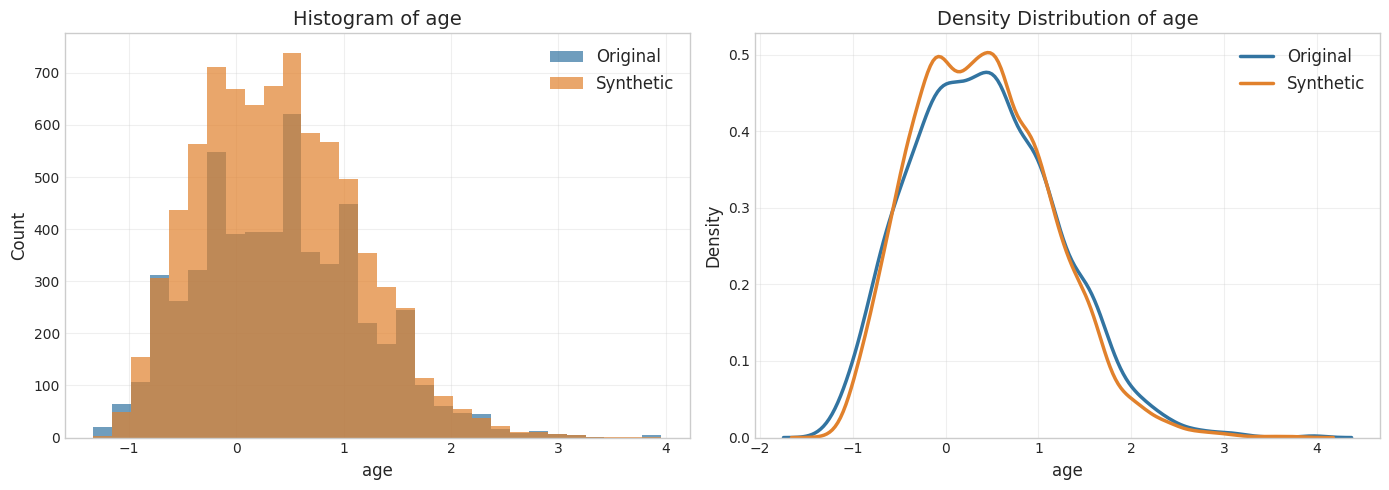

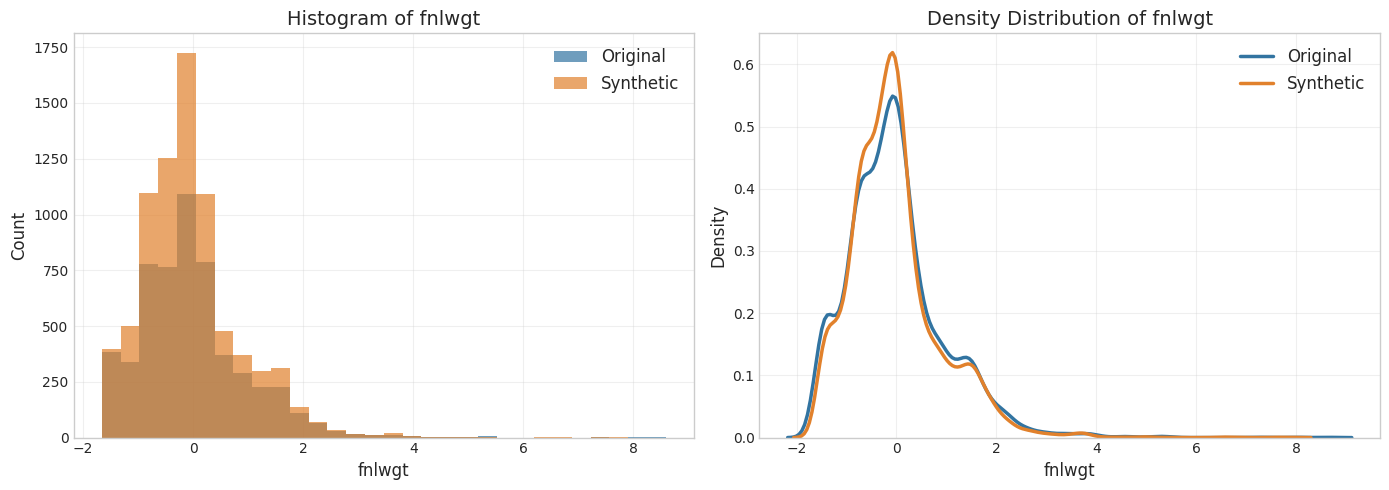

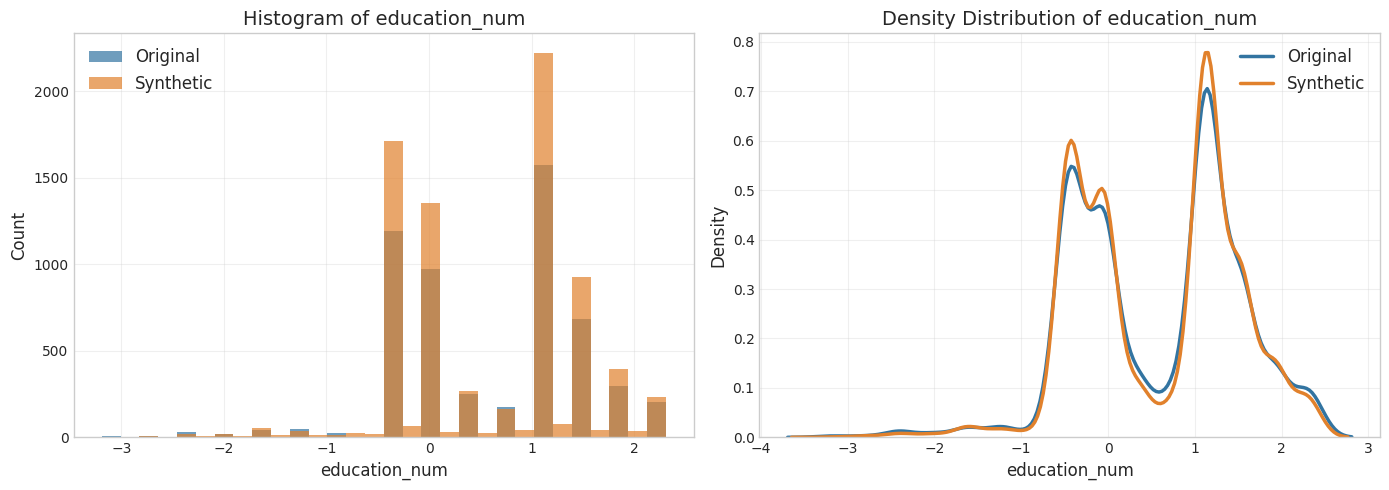

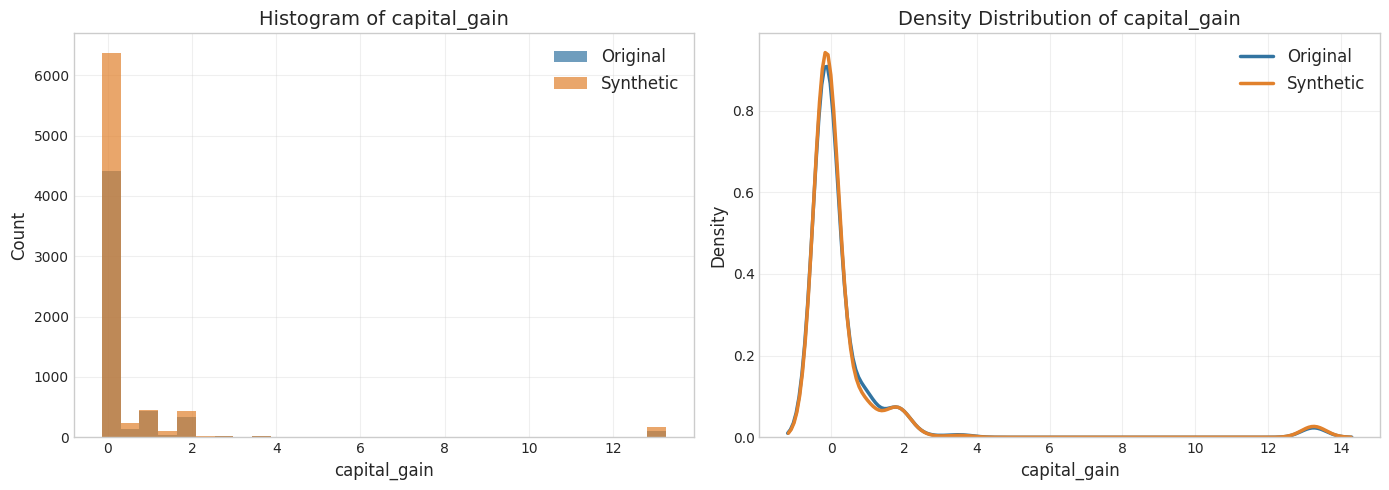

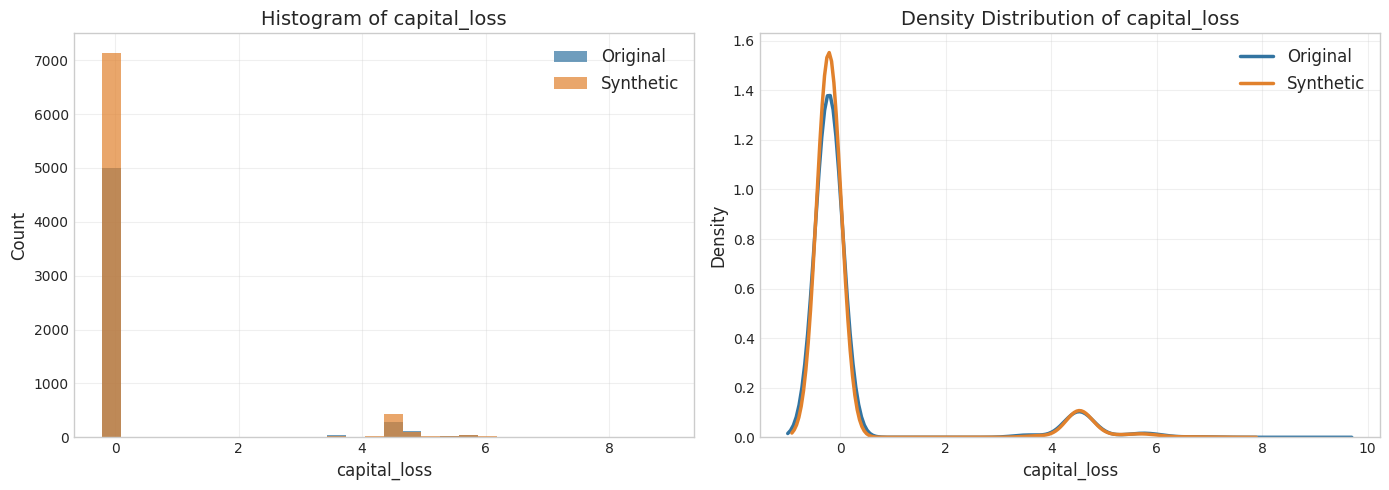

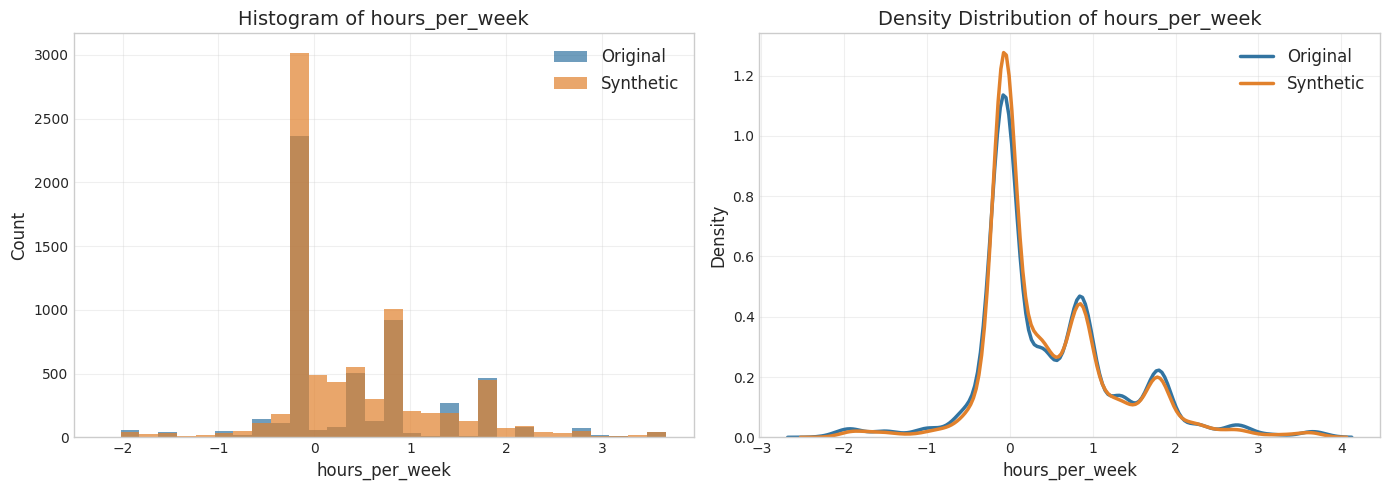

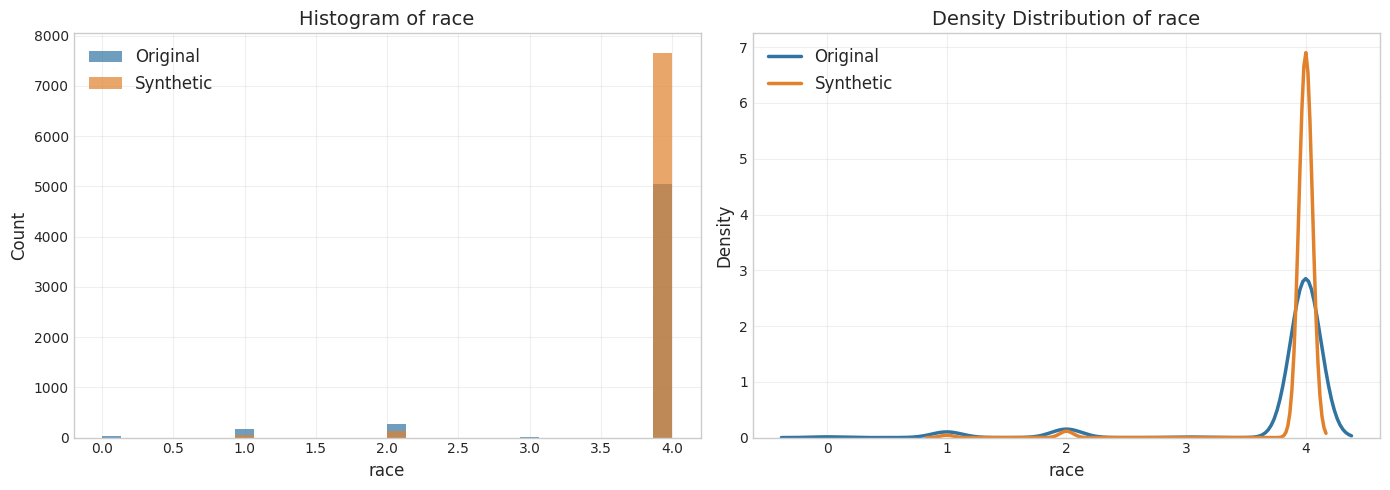

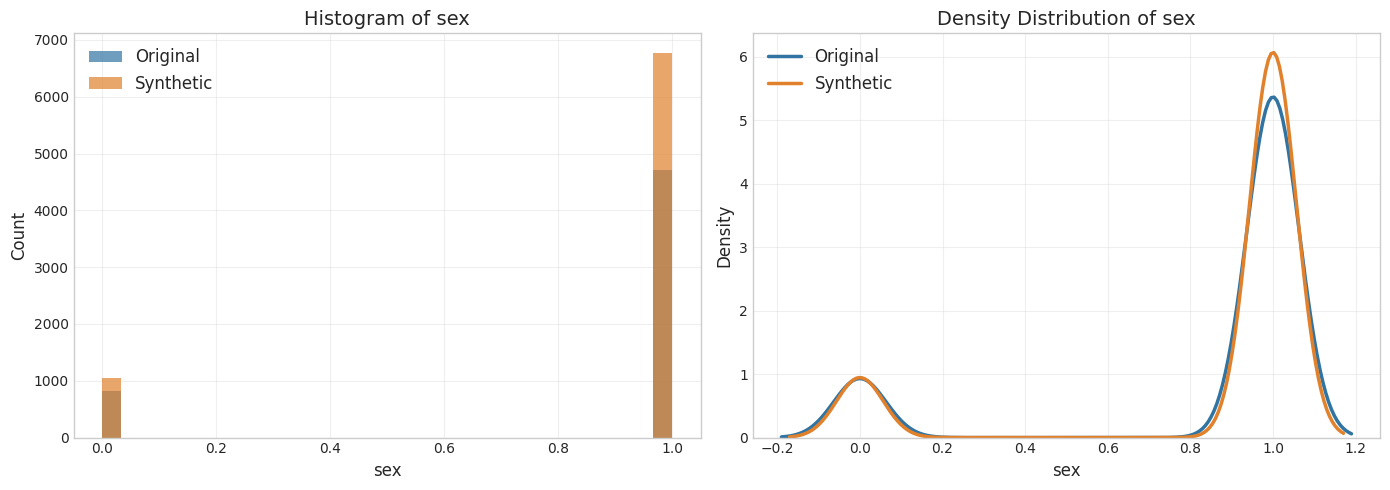

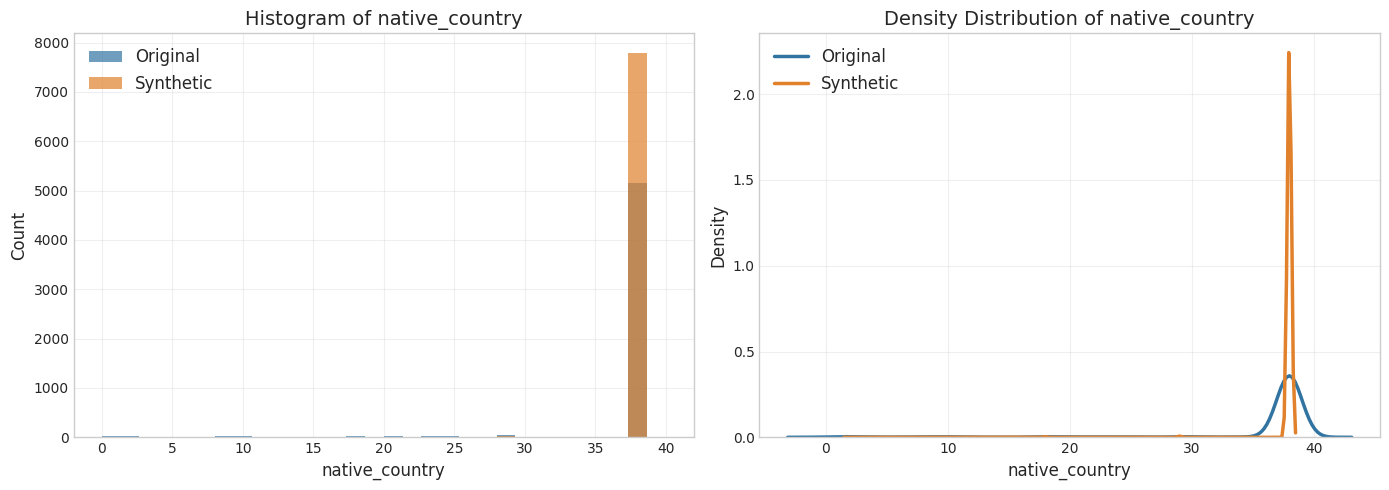

Generating 2D feature space visualization...


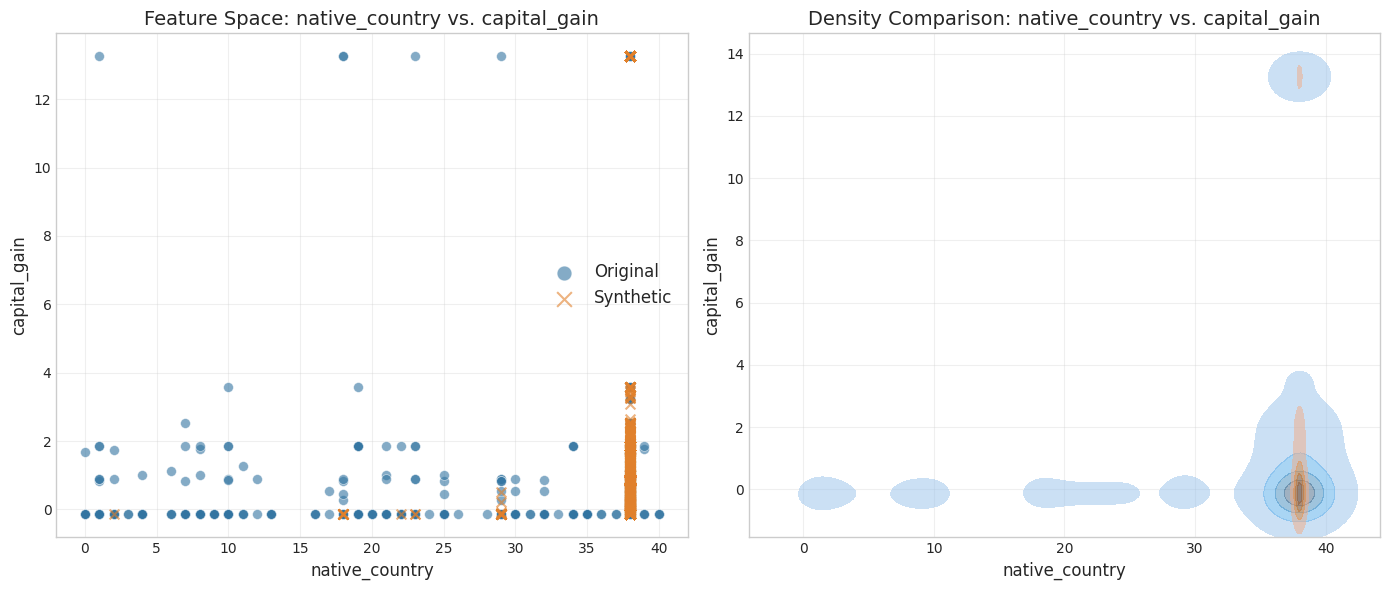


### SYNTHETIC DATA VALIDATION SUMMARY ###
Original samples: 5526
Synthetic samples: 7834
Features with statistically similar distributions: 3/9
Overall quality rating: Fair (score: 0.58)
Validation metrics:
{'sample_sizes': {'original_minority': 5526, 'synthetic': 7834, 'augmentation_ratio': 1.417661961635903}, 'continuous': {'age': {'orig_mean': 0.41682388430345935, 'orig_std': 0.7776253589891117, 'synth_mean': 0.3974346031972789, 'synth_std': 0.7276953966582339, 'mean_diff_pct': 4.651672285665977, 'std_diff_pct': 6.420824855272869, 'ks_stat': 0.035146222221852624, 'ks_p': 0.0006468706104247499}, 'fnlwgt': {'orig_mean': -0.019132110835100455, 'orig_std': 0.9689117186653692, 'synth_mean': -0.04207353746944685, 'synth_std': 0.8996905093923169, 'mean_diff_pct': 119.91058818380476, 'std_diff_pct': 7.144222527146364, 'ks_stat': 0.031239423244040217, 'ks_p': 0.003487001957318456}, 'education_num': {'orig_mean': 0.5840495148235989, 'orig_std': 0.9334381852603398, 'synth_mean': 0.58259227572

  race=3: Original=1.0000, Augmented=1.0000, Diff=0.0000
  race=4: Original=1.0000, Augmented=1.0000, Diff=0.0000
Average absolute difference: 0.0000
Maximum absolute difference: 0.0000
### Conditional Demographic Parity for sex ###
Conditional probabilities of positive outcome:
  sex=0: Original=1.0000, Augmented=1.0000, Diff=0.0000
  sex=1: Original=1.0000, Augmented=1.0000, Diff=0.0000
Average absolute difference: 0.0000
Maximum absolute difference: 0.0000
### Conditional Demographic Parity for native_country ###
Conditional probabilities of positive outcome:
  native_country=0: Original=1.0000, Augmented=1.0000, Diff=0.0000
  native_country=1: Original=1.0000, Augmented=1.0000, Diff=0.0000
  native_country=2: Original=1.0000, Augmented=1.0000, Diff=0.0000
  native_country=3: Original=1.0000, Augmented=1.0000, Diff=0.0000
  native_country=4: Original=1.0000, Augmented=1.0000, Diff=0.0000
  native_country=6: Original=1.0000, Augmented=1.0000, Diff=0.0000
  native_country=7: Original=

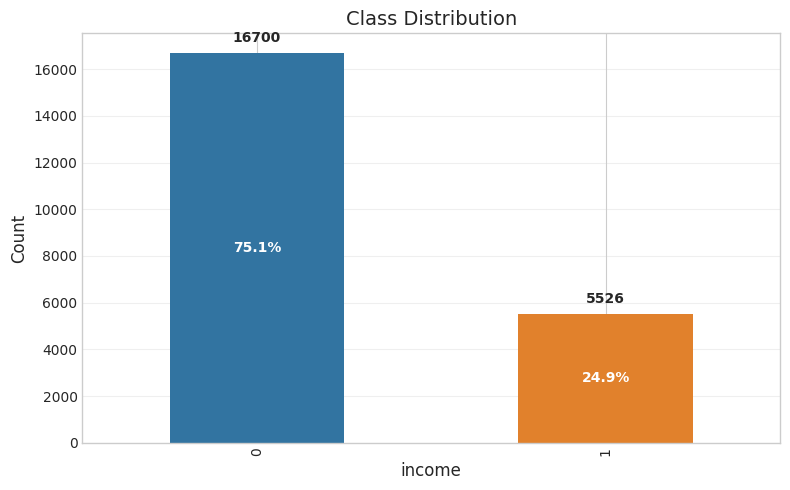

Class distribution:
  Class 0: 16700 samples (55.6%)
  Class 1: 13360 samples (44.4%)
Class imbalance ratio (majority:minority): 1.25:1


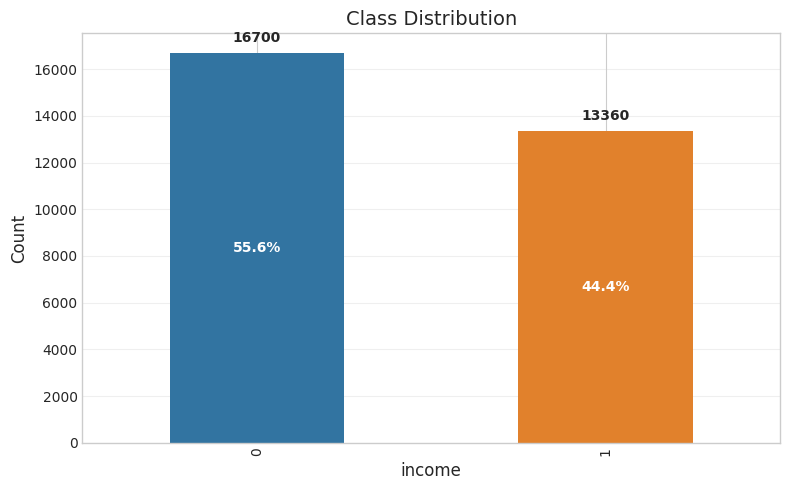

Class distribution:
  Class 0: 5567 samples (75.1%)
  Class 1: 1842 samples (24.9%)
Class imbalance ratio (majority:minority): 3.02:1


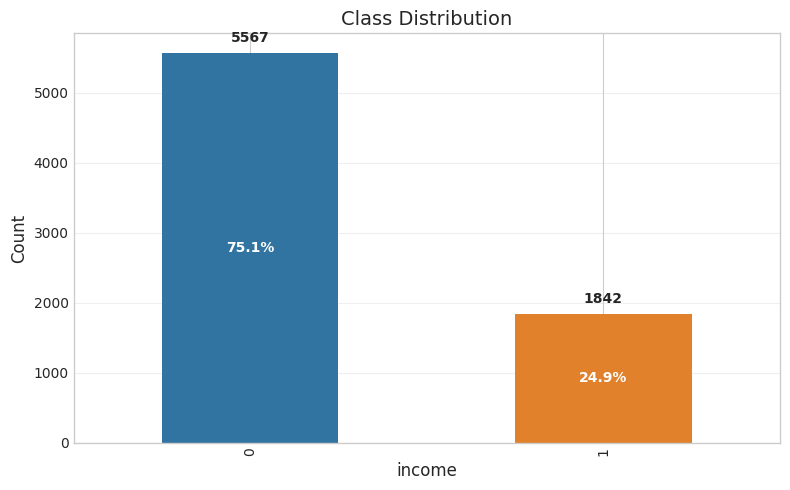

{'counts': {0: 5567, 1: 1842},
 'proportions': {0: 0.7513834525577001, 1: 0.2486165474422999},
 'imbalance_ratio': 3.022258414766558,
 'majority_class': 0,
 'minority_class': 1}

In [4]:
import pandas as pd
from ValidationMethods.BinaryDatasetValidation1 import validate_synthetic_data, analyze_class_distribution
from ValidationMethods.fairnessBiasCheck import fairness_assessment, print_simplified_fairness_report

# Load the CSV files generated by the augmentation process.
# (These files are assumed to have been generated using an oversampling method such as BORDERLINE-SMOTE adapted for the Adult dataset.)
original_train2 = pd.read_csv("OutputTrainingSets/original_trainVALIDATE3.csv")
augmented_train2 = pd.read_csv("OutputTrainingSets/augmented_trainVALIDATE3.csv")
test_set2 = pd.read_csv("OutputTrainingSets/test_setVALIDATE3.csv")
    
# Define the columns to keep: continuous features + target.
continuous_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'race', 'sex', 'native_country']
categorical_features = ["income"]
cols_to_keep = continuous_features + categorical_features
    
original_train2 = original_train2[cols_to_keep].dropna()
augmented_train2 = augmented_train2[cols_to_keep].dropna()
    
target = "income"
minority_class = 1  # Assuming the minority class is those with income >50K.
    
# Extract the minority class samples from the original training data.
original_minority = original_train2[original_train2[target] == minority_class]
    
# In the augmented training file, synthetic samples are appended after the original training data.
num_original = original_train2.shape[0]
synthetic_all = augmented_train2.iloc[num_original:]
synthetic_minority = synthetic_all[synthetic_all[target] == minority_class]
    
# Run the validation analysis.

metrics = validate_synthetic_data(
    original_train2,
    augmented_train2,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    target=target,
    synthetic_column='synthetic',  # Add this parameter
    distance_threshold=0.5,
    density_threshold=0.5,
    gamma=1.0,
    plot=True
)
    
print("Validation metrics:")
print(metrics)

sensitive_features = ['race', 'sex', 'native_country']
results = fairness_assessment(original_train2, augmented_train2, sensitive_features, target)
print_simplified_fairness_report(results)

analyze_class_distribution(original_train2, target=target)
analyze_class_distribution(augmented_train2, target=target)
analyze_class_distribution(test_set2, target=target)

# Validation Stage Analysis

## 3.1 Data Integrity Checks

### 3.1.1 Duplicate Detection 
 - 126 Synthetic samples were found that exactly match original data points, these were then removed.
 
### 3.1.2 Scaling & Normalisation  
- age:
    - Original: Mean = 43.538, STD = 10.022
    - Synthetic: Mean 43.132, STD = 8.104
- fnlwgt: 
    - Original: Mean = 187221.924, STD = 101367.466
    - Synthetic: Mean 189643.163, STD = 104474.063
- education_num: 
    - Original: Mean = 11.478, STD = 2.343
    - Synthetic: Mean 11.061, STD = 1.944
    
....

- Most features show close alignment in terms of mean and range though differences in STD suggest the synthetic data is less variable in some areas. This makes sense though as Borderline-SMOTE is focused more on decision boundary areas and would therefore have less broad variation. 

## 3.2 Distributional Similarity Tests

### 3.2.1 Kolmogorov–Smirnov (KS) Tests  
- age: KS statistic = 0.059, p-value = 0.000 -> Significant difference
- fnlwgt: KS statistic = 0.013, p-value = 0.672 -> No significant difference
- education_num: KS statistic = 0.181, p-value = 0.000 -> Significant difference
- capital_gain: KS statistic = 0.107, p-value = 0.000 -> Significant difference
- capital_loss: KS statistic = 0.000, p-value = 1.000 -> No significant difference
- hours_per_week: KS statistic = 0.155, p-value = 0.000 -> Significant difference

- While the synthetic values for fnlwgt and capital_loss are similar to the original there are notable differences for age, education_num, capital_gain, and hours_per_week. This indicates that the synthetic data for these values is significantly different from the original. This may be the case due to the use of Borderline-SMOTE trying to focus on the borderline cases and will not be representative of the whole minority class rather a subsection.

### 3.2.2 Categorical Feature Validation  
- income: Original Count - 4523
          Synthetic Count - 8296
          Chi-sqaured test: 0.000 and p-value of 1.000
- The synthetic generation maintains the categorical distribution for income effectively, ensuring that class labels are well preserved.


## 3.3 Coverage, Diversity & Density
- Coverage:
    - Only 2.08% of the original samples have a synthetic neighbor within a distance of 0.5. This low coverage suggests that the synthetic samples are not well spread throughout the original minority space. This is due to the use of Borderline-SMOTE and trying to augment the area by the decision boundary. 
    
- Diversity:
    - Average pairwise distance among synthetic samples is approximately 111819.44 with a standard deviation of 96584.13. The high average distance and variability indicate notable diversity among the synthetic data points.
    
- Density:
    - Average local density is 0.000 neighbors within a 0.5 radius. The sparse local density might be a consequence of high-dimensional data. It confirms that synthetic samples are well seperated. 
    
## 3.4 Discriminative & Distribution Metrics
- Discriminative Score:
    - The classifier accuracy for distinguishing synthetic from original samples is 0.671. The value is higher than 0.5 which is the target value which means that the data is somewhat distinguishable from the real data, suggesting room for improvement. This is the result of more simple generation models such as SMOTE and its variants. 

- Maximum Mean Discrepancy (MMD):
    - MMD is nearly zero (0.000334) which implies that overall the distributions of the real and synthetic data are similar. 
    
## 3.5 Class Balance Comparison
- Income Class Ratios:
    - Different outputs show ratios of greater than 50k to less than 50k as 0.28 in original train and test datasets. The augmented training dataset has a ratio of 0.8. 

<br><br>

Overall the global distribution of synthetic data approximates the original there are discrepancies at the local feature-level and coverage levels but this is due to the explicit targeting of borderline cases. These metrics and diagrams are helpful to understand the state of the synthetic data that will be used for the machine learning model's performance. 
<br><br>

# Method Selection for Classification Algorithm

### XGBoost

**Characteristics**
- **Pros:**
  - High predictive performance on tabular data.
  - Capable of capturing complex non-linear interactions and feature dependencies.
  - Built-in regularisation helps reduce overfitting which is important when training on augmented data.
- **Cons:**
  - Requires careful tuning of hyperparameters such as learning rate, max depth.
  - More computationally intense compared to simpler models.
  - Model complexity can reduce interpretability.
- **Computational Requirements:**
  - Moderate to high; resource usage increases with dataset size and complexity.
- **Best Use Case:**
  - When achieving high predictive accuracy is critical, and the dataset exhibits complex non-liner relationships.
  - Particularly effective when synthetic data introduces subtle new patterns that need to be captured robustly.

### Random Forest

**Characteristics**
- **Pros:**
  - Robust to noise and outliers due to the averaging of multiple trees.
  - Handles high-dimensional data effectively.
  - Can absorb some variance introduced by synthetic data augmentation.
- **Cons:**
  - Requires more computational resources as the number of trees increases.
  - Less interpretable compared to simpler, linear models.
- **Computational Requirements:**
  - Moderate to high; depending on the number of trees and depth chosen; typically requires more memory and processing power than simpler models.
- **Best Use Case:**
  - Datasets with high-dimensional features and when improved generalisation is needed.
  - Suitable when synthetic data introduces some noise as the ensemble approach helps smooth out inconsistencies.

### Logistic Regression

**Characteristics**
- **Pros:**
  - Simple, fast, very interpretable.
  - Computationally efficient, making it ideal for quick baseline assessments. 
  - Works well when synthetic data successfully balances class distributions, enhancing minority signal detection.
- **Cons:**
  - Limited in capturing complex, non-linear relationships.
  - Sensitive to outliers and multicollinearity, which may affect performance if the data is noisy.
- **Computational Requirements:**
  - Low; scales well with large datasets.
- **Best Use Case:**
  - When interpretability and speed are the priorities of the user.

### K-Nearest Neighbors (KNN)

**Characteristics**
- **Pros:**
  - Simple and intuitive, requires the least parameter tuning.
  - Effective in capturing local patterns which is helpful when synthetic data augments sparser regions of the minority class.
- **Cons:**
  - Highly sensitive to the choice of k.
  - Computationally expensive at prediction time.
  - Performance may degrade in high-dimensional feature spaces due to dimensionality being a major weakness.
- **Computational Requirements:**
  - Low during training but high during inference, especially for large datasets.
- **Best Use Case:**
  - Datasets with low to moderate dimensionality where local relationships are paramount.
  - When a non-parametric approach is preferred.

Each of these classification algorithms has their respective advantages and optimal use cases. 

## Your Choice of Model & Rationalisation

- I chose to experiment with all four classification methods to explore how the synthetic data augmentation impacts different modeling paradigms. Each algorithm has unique characteristics and through implementing them all I can assess how well the synthetic data improves minority class detection and overall performance. This strategy helps highlight the strengths and potential limitations of synthetic data generation.

=== Original Training Model Metrics ===
Accuracy: 0.825
AUC: 0.861
Classification Report:
              precision    recall  f1-score      support
0              0.845271  0.939105  0.889721  5567.000000
1              0.723039  0.480456  0.577299  1842.000000
accuracy       0.825078  0.825078  0.825078     0.825078
macro avg      0.784155  0.709781  0.733510  7409.000000
weighted avg   0.814882  0.825078  0.812048  7409.000000
Confusion Matrix:
[[5228  339]
 [ 957  885]]

=== Augmented Training Model Metrics ===
Accuracy: 0.797
AUC: 0.859
Classification Report:
              precision    recall  f1-score      support
0              0.901403  0.819472  0.858487  5567.000000
1              0.571976  0.729099  0.641050  1842.000000
accuracy       0.797004  0.797004  0.797004     0.797004
macro avg      0.736690  0.774285  0.749769  7409.000000
weighted avg   0.819502  0.797004  0.804429  7409.000000
Confusion Matrix:
[[4562 1005]
 [ 499 1343]]


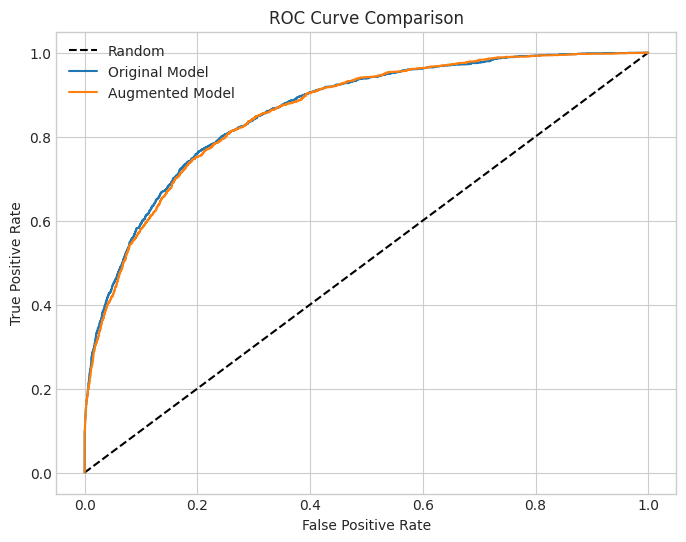

In [5]:
import pandas as pd
from MachineLearningModels.BinaryDatasetLogisticRegression import train_logistic_model, evaluate_model, compare_models

# Load CSV files.
original_train = pd.read_csv("OutputTrainingSets/original_trainVALIDATE3.csv")
augmented_train = pd.read_csv("OutputTrainingSets/augmented_trainVALIDATE3.csv")
test_set = pd.read_csv("OutputTrainingSets/test_setVALIDATE3.csv")

# Define the feature columns and target.
features = ['age', 'workclass', 'fnlwgt', 'education_num', 'marital_status','relationship','race', 'sex','capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
target = 'income'

# Train a Logistic Regression model on the original training dataset.
model_originalLR = train_logistic_model(original_train, features, target, random_state)
metrics_originalLR = evaluate_model(model_originalLR, test_set, features, target)

# Train a Logistic Regression model on the augmented training dataset.
model_augmentedLR = train_logistic_model(augmented_train, features, target, random_state)
metrics_augmentedLR = evaluate_model(model_augmentedLR, test_set, features, target)

# Compare the performance of the two models.
compare_models(metrics_originalLR, metrics_augmentedLR)

## 4. Model Performance Analysis (LR)

### 4.1 Overall Performance Metrics
    - Original model has a lower accuracy of (0.656) and slightly lower AUC (0.794) than the augmented model (0.741) accuracy and (0.809) AUC.
### 4.2 Precision–Recall Trade‑off
    - In the augmented model for the minority class, precision drops from 0.622 -> 0.444 however, recal increases substantially 0.147 -> 0.747. This results in a notable increase in f1-score for the minority class from 0.239 -> 0.557. 
    - The f1-score of the majority class is slightly negatively affected as it goes from 0.880 -> 0.816 however, it is not enough to be concerned and it is worth the improvement in performance for the minority class.
### 4.3 Confusion Matrix Insights
    - The augmented model is misclassifying fewer false positives for the minority class. The drawback is more majority samples are now misclassified as minority class. 
### 4.4 ROC Curve Comparison
    - The ROC curves shows the augmented model's stronger performance across a range of  decision thresholds. The AUC difference of (0.656) -> (0.805) 
## 4.5 Summary of Improvements & Drawbacks
    - There is a very substantial improvement for the minority-class recall and f1-score.
    - Slightly lower performance of the majority class.
    - More false positives for the minority class which shows in the drop in precision.
    - Potential overfitting.    

In [ ]:
import pandas as pd
from MachineLearningModels.BinaryDatasetXGBoostComparison import train_xgb_model, evaluate_model, compare_models

# Load CSV files.
original_train = pd.read_csv("OutputTrainingSets/original_trainBORDERLINE2.csv")
augmented_train = pd.read_csv("OutputTrainingSets/augmented_trainBORDERLINE2.csv")
test_set = pd.read_csv("OutputTrainingSets/test_setBORDERLINE2.csv")
    
# Define the feature columns and target.
# For the diabetes dataset, typical features are:
# Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, and Pregnancies.
features = ['age', 'workclass', 'fnlwgt', 'education_num', 'marital_status','relationship','race', 'sex','capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
target = 'income'
    
# Train an XGBoost model on the original training dataset.
model_originalXGBoost = train_xgb_model(original_train, features, target)
metrics_originalXGBoost = evaluate_model(model_originalXGBoost, test_set, features, target)
    
# Train an XGBoost model on the augmented training dataset.
model_augmentedXGBoost = train_xgb_model(augmented_train, features, target)
metrics_augmentedXGBoost = evaluate_model(model_augmentedXGBoost, test_set, features, target)
    
# Compare the performance of the two models.
compare_models(metrics_originalXGBoost, metrics_augmentedXGBoost)

=== Original Training Model Metrics ===
Accuracy: 0.852
AUC: 0.902
Classification Report:
              precision    recall  f1-score      support
0              0.888561  0.918089  0.903083  5567.000000
1              0.724804  0.652009  0.686482  1842.000000
accuracy       0.851937  0.851937  0.851937     0.851937
macro avg      0.806682  0.785049  0.794783  7409.000000
weighted avg   0.847848  0.851937  0.849233  7409.000000
Confusion Matrix:
[[5111  456]
 [ 641 1201]]

=== Augmented Training Model Metrics ===
Accuracy: 0.842
AUC: 0.899
Classification Report:
              precision    recall  f1-score      support
0              0.903617  0.884139  0.893772  5567.000000
1              0.671254  0.714984  0.692429  1842.000000
accuracy       0.842084  0.842084  0.842084     0.842084
macro avg      0.787435  0.799561  0.793100  7409.000000
weighted avg   0.845847  0.842084  0.843714  7409.000000
Confusion Matrix:
[[4922  645]
 [ 525 1317]]


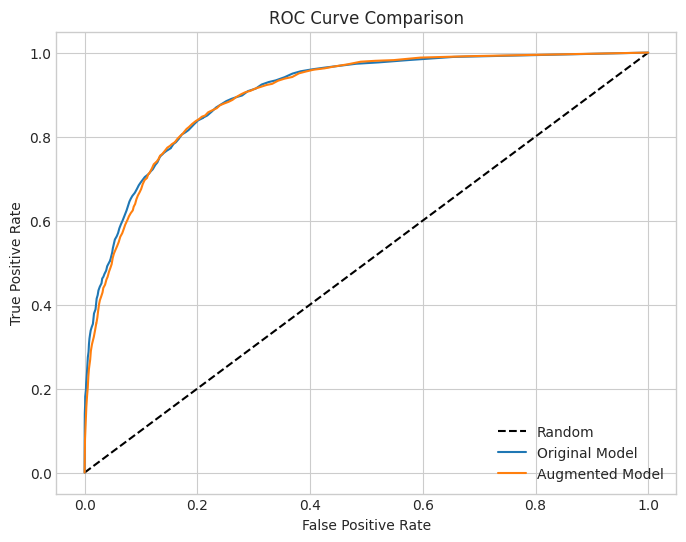

In [7]:
import pandas as pd
from MachineLearningModels.BinaryDatasetRandomForest import train_rf_model, evaluate_model, compare_models

# Load CSV files.
original_train = pd.read_csv("OutputTrainingSets/original_trainBORDERLINE2.csv")
augmented_train = pd.read_csv("OutputTrainingSets/augmented_trainBORDERLINE2.csv")
test_set = pd.read_csv("OutputTrainingSets/test_setBORDERLINE2.csv")

# Define the feature columns and target.
features = ['age', 'workclass', 'fnlwgt', 'education_num', 'marital_status','relationship','race', 'sex','capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
target = 'income'

# Train a Random Forest model on the original training dataset.
model_originalRF = train_rf_model(original_train, features, target)
metrics_originalRF = evaluate_model(model_originalRF, test_set, features, target)

# Train a Random Forest model on the augmented training dataset.
model_augmentedRF = train_rf_model(augmented_train, features, target)
metrics_augmentedRF = evaluate_model(model_augmentedRF, test_set, features, target)

# Compare the performance of the two models.
compare_models(metrics_originalRF, metrics_augmentedRF)

## 4. Model Performance Analysis (RF)

### 4.1 Overall Performance Metrics
    - Original model has a slightly higher accuracy of (0.842) and slightly higher AUC (0.881) than the augmented model (0.823) accuracy and (0.870) AUC.
### 4.2 Precision–Recall Trade‑off
    - In the augmented model for the minority class, precision drops from 0.674 -> 0.585 however, recal increases substantially 0.533 -> 0.649. This results in a subtle increase in f1-score for the minority class from 0.595 -> 0.615. 
    - The f1-score of the majority class is slightly negatively affected as it goes from 0.901 -> 0.884 however, it is not enough to be concerned and it is worth the improvement in performance for the minority class.
### 4.3 Confusion Matrix Insights
    - The augmented model is misclassifying fewer true positives as negatives. The drawback is more negatives are now labeled as positives. This is a common trend within synthetic data augmentation.
### 4.4 ROC Curve Comparison
    - The ROC curves are extremely similar, the augmented curve is slightly below the original's. This suggests that both models discriminate similarly. 
## 4.5 Summary of Improvements & Drawbacks
    - There is a substantial improvement for the minority-class recall and small notable f1-score increase.
    - Slightly lower overall accuracy and AUC.
    - More false positives for the minority class which shows in the drop in precision.
    - Potential overfitting.    

=== Original Training Model Metrics ===
Accuracy: 0.829
AUC: 0.858
Classification Report:
              precision    recall  f1-score      support
0              0.871994  0.905515  0.888438  5567.000000
1              0.676904  0.598263  0.635159  1842.000000
accuracy       0.829127  0.829127  0.829127     0.829127
macro avg      0.774449  0.751889  0.761798  7409.000000
weighted avg   0.823492  0.829127  0.825469  7409.000000
Confusion Matrix:
[[5041  526]
 [ 740 1102]]

=== Augmented Training Model Metrics ===
Accuracy: 0.806
AUC: 0.856
Classification Report:
              precision    recall  f1-score      support
0              0.905005  0.828274  0.864941  5567.000000
1              0.586863  0.737242  0.653513  1842.000000
accuracy       0.805642  0.805642  0.805642     0.805642
macro avg      0.745934  0.782758  0.759227  7409.000000
weighted avg   0.825909  0.805642  0.812376  7409.000000
Confusion Matrix:
[[4611  956]
 [ 484 1358]]


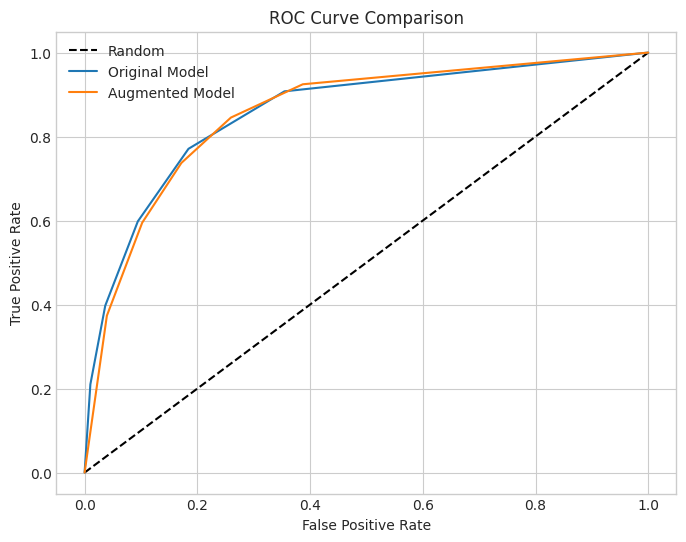

In [8]:
import pandas as pd
from MachineLearningModels.BinaryDatasetKNN import train_knn_model, evaluate_model, compare_models

# Load CSV files.
original_train = pd.read_csv("OutputTrainingSets/original_trainBORDERLINE2.csv")
augmented_train = pd.read_csv("OutputTrainingSets/augmented_trainBORDERLINE2.csv")
test_set = pd.read_csv("OutputTrainingSets/test_setBORDERLINE2.csv")

# Define the feature columns and target.
features = ['age', 'workclass', 'fnlwgt', 'education_num', 'marital_status','relationship','race', 'sex','capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
target = 'income'

# Train a KNN model on the original training dataset.
model_originalKNN = train_knn_model(original_train, features, target)
metrics_originalKNN = evaluate_model(model_originalKNN, test_set, features, target)

# Train a KNN model on the augmented training dataset.
model_augmentedKNN = train_knn_model(augmented_train, features, target)
metrics_augmentedKNN = evaluate_model(model_augmentedKNN, test_set, features, target)

# Compare the performance of the two models.
compare_models(metrics_originalKNN, metrics_augmentedKNN)


## 4. Model Performance Analysis (KNN)

### 4.1 Overall Performance Metrics
    - Original model has a slightly higher accuracy of (0.773) and slightly lower AUC (0.615) than the augmented model (0.645) accuracy and (0.619) AUC.
### 4.2 Precision–Recall Trade‑off
    - In the augmented model for the minority class, precision drops from 0.457 -> 0.303 however, recal increases substantially 0.215 -> 0.482. This results in an increase in f1-score for the minority class from 0.293 -> 0.372. 
    - The f1-score of the majority class is somewhat negatively affected as it goes from 0.864 -> 0.752 however, it is not enough to be concerned and it is worth the improvement in performance for the minority class.
### 4.3 Confusion Matrix Insights
    - The augmented model is misclassifying fewer false negatives. 
### 4.4 ROC Curve Comparison
    - The ROC curves are extremely similar. This suggests that both models discriminate similarly. 
## 4.5 Summary of Improvements & Drawbacks
    - There is a substantial improvement for the minority-class recall and small notable f1-score increase.
    - Slightly lower overall accuracy but higher AUC.
    - Potential overfitting.    

In [9]:
from ValidationMethods.subgroupAnalysis import evaluate_model_by_group, compare_group_metrics, analyse_intersectional_groups

sensitive_attributes = ['race', 'sex', 'native_country']

# Evaluate models by group
original_group_metrics = evaluate_model_by_group(model_originalXGBoost, test_set, features, target, sensitive_attributes)
augmented_group_metrics = evaluate_model_by_group(model_augmentedXGBoost, test_set, features, target, sensitive_attributes)

# Compare metrics between original and augmented models
group_comparison = compare_group_metrics(original_group_metrics, augmented_group_metrics)

# Display results
for attr, groups in group_comparison.items():
    print(f"\n=== {attr.upper()} GROUP COMPARISON ===")
    for group, metrics in groups.items():
        print(f"\n{group} (n={metrics['count']}):")
        print(f"  Accuracy change: {metrics['accuracy_diff']:.4f}")
        print(f"  AUC change: {metrics['auc_diff']:.4f}")
        print(f"  Minority class recall change: {metrics['recall_diff_class1']:.4f}")
        print(f"  Minority class precision change: {metrics['precision_diff_class1']:.4f}")
        print(f"  Minority class F1 change: {metrics['f1_diff_class1']:.4f}")
        
intersect_orig = analyse_intersectional_groups(model_originalXGBoost, test_set, features, target, 'race', 'sex')
intersect_aug = analyse_intersectional_groups(model_augmentedXGBoost, test_set, features, target, 'race', 'sex')

print("\n=== INTERSECTIONAL ANALYSIS (RACE & GENDER) ===")
for group in set(intersect_orig.keys()).union(set(intersect_aug.keys())):
    if group in intersect_orig and group in intersect_aug:
        # Check if the group has both classes in both original and augmented results
        orig_has_minority = len(intersect_orig[group]['precision_recall_f1'][0]) > 1
        aug_has_minority = len(intersect_aug[group]['precision_recall_f1'][0]) > 1
        
        print(f"\n{group} (n={intersect_aug[group]['count']}):")
        print(f"  Accuracy: {intersect_orig[group]['accuracy']:.4f} → {intersect_aug[group]['accuracy']:.4f}")
        
        if orig_has_minority and aug_has_minority:
            orig_recall = intersect_orig[group]['precision_recall_f1'][1][1]
            aug_recall = intersect_aug[group]['precision_recall_f1'][1][1]
            print(f"  Minority class recall: {orig_recall:.4f} → {aug_recall:.4f} (Change: {aug_recall-orig_recall:.4f})")
        else:
            # Handle the case where one or both models predicted only one class for this group
            if not orig_has_minority and not aug_has_minority:
                print("  Minority class recall: Not applicable (no minority class predictions in either model)")
            elif not orig_has_minority:
                print("  Minority class recall: None → Present in augmented model")
            else:
                print("  Minority class recall: Present in original model → None")


=== SEX GROUP COMPARISON ===

0 (n=2424):
  Accuracy change: -0.0074
  AUC change: -0.0076
  Minority class recall change: 0.1158
  Minority class precision change: -0.1127
  Minority class F1 change: 0.0194

1 (n=4985):
  Accuracy change: -0.0183
  AUC change: -0.0058
  Minority class recall change: 0.1143
  Minority class precision change: -0.0871
  Minority class F1 change: 0.0116

=== NATIVE_COUNTRY GROUP COMPARISON ===

1 (n=22):
  Accuracy change: -0.0909
  AUC change: 0.0000
  Minority class recall change: -0.1667
  Minority class precision change: -0.1250
  Minority class F1 change: -0.1429

2 (n=19):
  Accuracy change: 0.0000
  AUC change: -0.0500
  Minority class recall change: 0.2500
  Minority class precision change: 0.0000
  Minority class F1 change: 0.1000

3 (n=15):
  Accuracy change: 0.0000
  AUC change: nan
  Minority class recall change: nan
  Minority class precision change: nan
  Minority class F1 change: nan

4 (n=24):
  Accuracy change: 0.0000
  AUC change: -0.01

# Ethical/Privacy Analysis 

Intersectional analysis was conducted and overall, performance was improved for many intersectional groups. This is very good as it shows that the model does not have any adverse effects on marginalised groups.

# Exporting Outputs of Framework Pipeline

A successful implementation of the framework and its pipeline outputs the following materials: datasets, model cards, trained classification models, and the notebook file the computation occured from. The rest of the document will be concerned with the documentation of the deployment, monitoring, and documentation of the framework's outputs. 

In [9]:
#CREATE FOLDER STRUCTURE FOR OUTPUTS

import os

# Define the main folder and a list of subfolder names
main_folder = "OutputMaterials"
subfolders = ["Datasets", "ModelCards", "TrainedModels"]

# Create the main folder if it doesn't already exist
os.makedirs(main_folder, exist_ok=True)

# Create each subfolder within the main folder
for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)
    os.makedirs(subfolder_path, exist_ok=True)

print(f"Created main folder '{main_folder}' with subfolders: {', '.join(subfolders)}")

Created main folder 'OutputMaterials' with subfolders: Datasets, ModelCards, TrainedModels


In [11]:
# SAVE CONFIG to JSON file
# At the end of your notebook, import the export_pipeline_config function.
from exportJSON import export_pipeline_config, compute_evaluation_metrics

# --- Live Pipeline Configuration Values ---

# Synthetic generation details (from your synthetic augmentation segment)
synthetic_method = "Borderline-SMOTE"

# The synthetic data generation function used in the pipeline
# (Assume augment_dataframe_borderline_smote was imported or defined previously)
augmentation_filee = "BorderlineSMOTE.py"
pipeline_name = "AdultsMarkdownBORDERLINE.ipynb"
validation_filee = "BinaryDatasetValidation1.py"
data_file_names = ["original_trainBORDERLINE2.csv", "augmented_trainBORDERLINE2.csv", "test_setBORDERLINE2.csv"]

evaluation_metrics = compute_evaluation_metrics(original_minority, synthetic_minority, continuous_features, categorical_features,
                                         distance_threshold=0.5, density_threshold=0.5, gamma=1.0, plot = False)
# Output JSON filename
output_json = "OutputMaterials/AdultsPipelineConfig.json"

# --- Export the Pipeline Configuration ---
export_pipeline_config(
    dataset_name=dataset_name,
    features=features,
    train_test_ratio=test_size,
    randomState = random_state,
    synthetic_method=synthetic_method,
    augmentation_ratio=ratio_limit,
    augmentation_file = augmentation_filee,
    pipeline_name = pipeline_name,
    validation_file = validation_filee,
    evaluation_metrics = evaluation_metrics,
    data_file_name = data_file_names,
    output_json=output_json
)

Configuration exported to OutputMaterials/AdultsPipelineConfig.json


In [12]:
#Save ML Models
import joblib

#XGBoost
joblib.dump(model_originalXGBoost, "OutputMaterials/TrainedModels/XGBoost_model_original.pkl")
print("Original XGBoost model saved as 'XGBoost_model_original.pkl'")
joblib.dump(model_augmentedXGBoost, "OutputMaterials/TrainedModels/XGBoost_model_augmented.pkl")
print("Original XGBoost model saved as 'XGBoost_model_augmented.pkl'")

#Logistic Regression
joblib.dump(model_originalLR, "OutputMaterials/TrainedModels/LR_model_original.pkl")
print("Original LR model saved as 'LR_model_original.pkl'")
joblib.dump(model_augmentedLR, "OutputMaterials/TrainedModels/LR_model_augmented.pkl")
print("Original LR model saved as 'LR_model_augmented.pkl'")

#Random Forest
joblib.dump(model_originalRF, "OutputMaterials/TrainedModels/RF_model_original.pkl")
print("Original RF model saved as 'RF_model_original.pkl'")
joblib.dump(model_augmentedRF, "OutputMaterials/TrainedModels/RF_model_augmented.pkl")
print("Original RF model saved as 'RF_model_augmented.pkl'")

#K-nearest Neighbors
joblib.dump(model_originalKNN, "OutputMaterials/TrainedModels/KNN_model_original.pkl")
print("Original KNN model saved as 'KNN_model_original.pkl'")
joblib.dump(model_augmentedKNN, "OutputMaterials/TrainedModels/KNN_model_augmented.pkl")
print("Original KNN model saved as 'KNN_model_augmented.pkl'")

Original XGBoost model saved as 'XGBoost_model_original.pkl'
Original XGBoost model saved as 'XGBoost_model_augmented.pkl'
Original LR model saved as 'LR_model_original.pkl'
Original LR model saved as 'LR_model_augmented.pkl'
Original RF model saved as 'RF_model_original.pkl'
Original RF model saved as 'RF_model_augmented.pkl'
Original KNN model saved as 'KNN_model_original.pkl'
Original KNN model saved as 'KNN_model_augmented.pkl'


In [13]:
# Move Data into Folder
original_train_clean.to_csv("OutputMaterials/Datasets/original_trainBORDERLINE2.csv", index=False)
augmented_train_clean.to_csv("OutputMaterials/Datasets/augmented_trainBORDERLINE2.csv", index=False)
test_set_clean.to_csv("OutputMaterials/Datasets/test_setBORDERLINE2.csv", index=False)

In [14]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Original XGBoost for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "original_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalXGBoost
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/XGBoost_original_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/XGBoost_original_ModelCard.md


In [15]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Augmented XGBoost for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "augmented_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalXGBoost
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/XGBoost_augmented_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/XGBoost_augmented_ModelCard.md


In [16]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Original Logistic Regression for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "original_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalLR
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/LR_original_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/LR_original_ModelCard.md


In [17]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Augmented Logistic Regression for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "augmented_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalLR
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/LR_augmented_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/LR_augmented_ModelCard.md


In [18]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Original Random Forest for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "original_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalRF
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/RF_original_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/RF_original_ModelCard.md


In [19]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Augmented Random Forest for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "augmented_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalRF
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/RF_augmented_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/RF_augmented_ModelCard.md


In [20]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Original KNN for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "original_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalKNN
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/KNN_original_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/KNN_original_ModelCard.md


In [21]:
#Create and store model card
from MachineLearningModels.ModelCardMaker import create_model_card
import pandas as pd

model_name = "Augmented KNN for Synthetic Data Augmentation"
overview = "Name of relevant dataset is " + dataset_name + ", this ML model was trained to classify the target value of " + target
preproc_file = "DataPrepv1.py"
train_set_name = "augmented_trainBORDERLINE2.csv"
test_set_name = "test_setBORDERLINE2.csv"
evaluation_metrics = metrics_originalKNN
intended_use = "Classify the target value of " + target + " as well as possible."
ethical_bias_concerns = "Works with potentially sensitive data including race, sex, and country of origin."
output_filename = "OutputMaterials/ModelCards/KNN_augmented_ModelCard.md"

create_model_card(model_name, overview, preproc_file, random_state,
                  test_size, features, target, train_set_name, test_set_name,
                  evaluation_metrics, intended_use, ethical_bias_concerns, output_filename)

Model card saved as OutputMaterials/ModelCards/KNN_augmented_ModelCard.md


In [22]:
#Create README.txt file

readme_content = f"""
# Output Materials for Synthetic Data Generation Framework for the AdultsUCI Dataset

This folder contains all the output artifacts from the synthetic data generation and evaluation pipeline. These materials are designed to be self-contained and reproducible, and they can be zipped and shared with others for further analysis or deployment.

## Contents

- **Trained Models:**  
  Trained machine learning models (Logistic Regression, KNN, Random Forest, XGBoost) saved as pickle files.
  
- **Configuration Files:**  
  JSON files detailing the pipeline configuration, including dataset information, preprocessing steps, synthetic data generation parameters, and evaluation metrics.  
  *Filename:* `AdultsPipelineConfig.json`

- **Model Cards:**  
  Markdown files that document each model's details, including:
  - Overview and intended use
  - Dataset information (original vs. augmented)
  - Preprocessing details
  - Hyperparameters and training details
  - Evaluation metrics and performance results
  - Ethical and bias considerations

- **Evaluation Outputs:**  
  Files containing evaluation metrics.

## How to Use

1. **Review Configuration:**  
   Open the configuration JSON files to see the exact parameters and settings used during the pipeline execution.

2. **Examine Model Cards:**  
   Each model card provides a detailed description of the corresponding model. Use these documents to understand how the model was trained, evaluated, and any known limitations or ethical concerns.

3. **Load and Deploy Models:**  
   Trained models can be loaded using joblib (or pickle). For example:
   ```python
   import joblib
   model = joblib.load("model.pkl")
"""

with open("OutputMaterials/README.txt", "w") as file:
    file.write(readme_content)
    
print("Content saved to README.txt")

Content saved to README.txt


# 5. Deployment and Monitoring

After validating that the machine learning model augmented with synthetic data performs positively on the test set, the next phase is deployment and continuous monitoring. For the UCI Adults dataset the goal was to improve classificaion for individuals earing greater than 50k. The deployment process must ensure that the synthetic data augmentation does not introduce unintended distortions.

---

### Key Points

- **Model Integration:**  
  - The trained model including all pre-processing steps such as scaling, encoding, and feature transformations is saved as a complete artifact. Synthetic data use in the training was intended to improve minority class detection. The deployed model includes the use of a well-documented pre-processing pipeline. 
  
- **Documentation of Augmentation:**  
  - It is important to document the degree of augmentation applied. This includes details such as the percentage increase in the minority class, the diminishing factor applied for small classes, and the settings used for each step. This metadata is embedded within the model artifact and is referenced in the model card.
  
- **Monitoring for Data Drift:**
  - Once deployed (regardless of whether on a cloud service or integrated into an enterprise system), the model will process incoming data, which may exhibit shifts in class distribution or feature drift over time. A monitoring routine should:
     - Track key performance metrics especially for the minority class.
     - Monitor the rate of predictions for the >50k class and frlag significant deviations from expected prevalence.
     - Periodically simulate known high-income cases to verify that the model's performance is consistent.
     - Trigger alerts or automatic retraining if performance metrics such as recall or F1-score for the minority class drop below defined thresholds.
     
- **Re-Training and Version Control:**
  - If monitoring reveals persistent changes in data distributions or performance degradation, the entire piepline including synthetic data generation should be re-run with the updated dataset. Freshly augmented datasets should replace older versions. Use version control systems (Github) and metadata logging to ensure that every retraining iteration is reproducible and that audit trails are maintained. 
  
- **A/B Testing and Resource Monitoring:**
   - Implement an A/B testing framework to compare the new augmented model against the current production model before full rollout. Monitor system resources including memory, latency, CPU/GPU usage to ensure deployed model meets real-time operational constraints.

# 6. Documentation & Ethics Review

Throughout the lifecycle of the model for predicting greater than 50k income using the UCI Adults dataset, detailed documentation and ethics reviews are integral to maintaining transparency, fairness, and regulatory compliance. 

---

### Documentation

- **Parameter and Process Logs:**  
  - Every step fo data processing, model training, and synthetic augmentation is documented. This includes details on feature scaling, encoding, outlier removal, and the exact settings used for synthetic data generation (augmentation ratios, diminishing factors, epochs). 
  
- **Model Cards and Technical Reports:**  
  - A model card is generated, detailing the intended use of the model, performance metrics across classes, limitations, and the role of synthetic data in improving minority class predictions. A breif README file will also be created.

### Ethics Review

- **Bias and Fairness Evaluation:**
   - Conduct ethics reviews focusing on whether the synthetic data augmentation process inadvertently introducs bias. Given the Adults dataset includes potentially sensitive attributes such as workclass and native country to give greater context, fairness metrics such as equal opportunity or equalised offs could be calculated and any shifts in representation should be flagged.
   
- **Privacy Considerations:** 
   - The dataset is anonymised from the start as the dataset that UCI offers to the public does not contain PPI such as names or other information that can lead to the identification of the people this data is based on.
   
- **Transparency and Accountability:**
   - All decisions related to this entire process have been recorded and documented. Ethics reviews document the rationale behind augmentation choices, the methods used for evaluation and any adjustments made following bias or fairness assessments. 
   
### Regulatory and Audit Readiness
- The complete documentation package covering data preprocessing, synthetic data generation, model training, and performance monitoring ensures that the deployment is prepare for an audit.

# Conclusion

In conclusion, this notebook contains an end-to-end pipeline for addressing class imbalance through synthetic data augmentation. The framework emphasises following the process in a manner that sets users up for the highest rate of success. This document has output augmented classification model package which have an improved rate of classification for the minority class. If there are any problems or concerns users can return to this document and the output materials package which enables full transparency. 


In [23]:
#EXPORT PIPELINE

import os
import shutil
#Copy this file over to OutputMaterials folder.

#SAVE FILE FIRST
source_file = "AdultsMarkdownBorderline.ipynb"  # Replace notebook's filename.
destination_folder = "OutputMaterials/"

destination_file = os.path.join(destination_folder, os.path.basename(source_file))
shutil.copy(source_file, destination_file)

print(f"Notebook copied from {source_file} to {destination_file}")

Notebook copied from AdultsMarkdownBORDERLINE.ipynb to OutputMaterials/AdultsMarkdownBORDERLINE.ipynb
